# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"

## Estudiantes: 

- Hernández Mancipe Daniel Felipe
- Panadero de las Heras José Luis 
- Thoux Durán Alejandro Napoleón 
- Velastegui Izurieta Homero Javier 

# **Introducción**

En el presente proyecto se utilizó una instancia **g4dn.2xlarge de** AWS que está diseñada para tareas de aprendizaje automático, inferencia y procesamiento gráfico moderado. Cuenta con 8 vCPUs basadas en procesadores Intel Xeon escalables, 32 GB de memoria RAM y una GPU NVIDIA T4 con 16 GB de memoria de video, lo que permite acelerar modelos de deep learning, análisis de imágenes, renderizado y aplicaciones con CUDA. Además, incluye NVMe local de alto rendimiento (aprox. 225 GB) para acceso rápido a datos temporales, hasta 25 Gbps de ancho de banda de red y soporte para EBS para almacenamiento adicional. Está optimizada para entrenamiento de modelos pequeños o medianos, inferencia en producción, desarrollo de modelos y aplicaciones de visualización 3D.

Dado que se utilizó una instancia remota, algunas etapas del entrenamiento se ejecutaron mediante scripts en Python gestionados con tmux, en lugar de seguir íntegramente la estructura de ejecución típica en Jupyter Notebook. Esto se debe a que Jupyter Lab, aunque útil para exploración, prototipado y visualización, puede interrumpir el entrenamiento si la sesión web se cierra o si existe inestabilidad en la conexión. En cambio, el uso de scripts junto con tmux permite mantener el proceso activo en segundo plano de forma persistente, incluso si el usuario cierra la terminal o el navegador, garantizando continuidad en entrenamientos prolongados.

Por ello, el proyecto se desarrolló de forma híbrida: se realizaron fases de análisis exploratorio, pruebas y visualizaciones en Jupyter Lab, mientras que los entrenamientos definitivos y la ejecución de modelos se llevaron a cabo mediante scripts independientes en la instancia, asegurando estabilidad y reportando los resultados en este documento.


## 1. Descripción del Dataset

El dataset asignado al Grupo 15 fue **Lemon Quality Dataset**,  este es un conjunto de imágenes orientado a la **clasificación automática de la calidad de limones** mediante técnicas de Visión por Computador y Aprendizaje Profundo. El dataset contiene imágenes capturadas bajo condiciones de iluminación natural y fondos uniformes, lo que facilita su uso en modelos basados en redes neuronales convolucionales (CNNs). Las imágenes muestran limones en diferentes estados de calidad, principalmente **limones en buen estado** y **limones deteriorados**, aunque la versión empleada en este proyecto incluye además una categoría adicional que representa **imágenes sin limón**.

## 2. Estructura y Organización del Dataset

En la versión utilizada en este proyecto, el dataset está organizado en tres carpetas, cada una correspondiente a una clase de clasificación:

| Carpeta             | Clase               | Descripción                                                                               |
|--------------------|--------------------|-------------------------------------------------------------------------------------------|
| `good_quality`      | Limón en buen estado | Imágenes de limones con apariencia fresca y sin signos visibles de daño o deterioro.      |
| `bad_quality`       | Limón en mal estado  | Imágenes de limones con señales de deterioro, manchas, podredumbre o deformaciones.       |
| `empty_background`  | Fondo vacío         | Imágenes sin limón útil en la escena; actúa como clase de control negativo.               |

Esta estructura permite formular una **tarea de clasificación multiclase**, donde el modelo debe aprender a distinguir visualmente entre limones buenos, limones en mal estado y ausencia de limón.

Aunque el número de imágenes puede variar según la versión descargada, en el presente proyecto la distribución del conjunto es la siguiente:

| Clase               | Nº aproximado de imágenes | Propósito en la clasificación |
|--------------------|--------------------------|------------------------------|
| `good_quality`       | 1125                    | Representa producto apto para comercialización. |
| `bad_quality`        | 952                     | Permite identificar fruta dañada o no apta.      |
| `empty_background`   | 452   | Ayuda al modelo a descartar imágenes irrelevantes. |

## 3. Objetivo del Dataset en el Contexto del Proyecto

El objetivo central del dataset es **servir como base para el entrenamiento, validación y evaluación de modelos de clasificación de imágenes** que permitan determinar automáticamente el estado de calidad de un limón. Este problema es una tarea de **clasificación visual aplicada**, donde las características que diferencian categorías son sutiles (manchas, textura de la cáscara, coloración, etc.).

En este proyecto, el dataset se empleará para comparar dos estrategias de aprendizaje profundo:

1. **Entrenamiento desde cero (from scratch):**  
   Se diseña y entrenará una CNN personalizada, aplicando técnicas de regularización, ajuste de hiperparámetros y data augmentation para optimizar el rendimiento.

2. **Transfer Learning con redes preentrenadas en ImageNet:**  
   Se utilizara arquitecturas profundas como **VGG, ResNet, MobileNet o Inception**, realizando ajuste fino (fine-tuning) para adaptar la red a la tarea específica de clasificación de limones.

---

# **Desarrollo**

El desarrollo del proyecto se realizó aplicando el paradigma de programación orientada a objetos. Para ello, se creó un directorio denominado modulos/, el cual contiene las clases que encapsulan la lógica necesaria para la carga de datos, el preprocesamiento, la construcción de modelos y el entrenamiento.
A lo largo de este informe, en cada sección se muestran únicamente las llamadas a los métodos correspondientes de dichas clases, con el fin de mantener el flujo del notebook claro y enfocado en el proceso experimental.

Adicionalmente, al final del documento se incluirá el código completo de las clases desarrolladas, con el propósito de proporcionar una visión integral y transparente de la solución implementada. 

## 1. Carga de datos desde la plataforma Kaggle

En primer lugar se genera un API de Kaggle personal, para ello:
1. Registrarse en  https://www.kaggle.com
2. Ir a 'Account tab' del perfil y seleccionar 'Create API Token', se descargará un `fichero kaggle.json`
3. Guardar el fichero kaggle.json en el directorio `~/.config/kaggle/kaggle.json` de la instancia en la que se ejecutará el entrenamiento.

Una vez colocado el token de acceso de Kaggle, es necesario instalar en la instancia la API, para ello en la terminal de Linux ejecutar:

```bash
pip install kaggle
```

Se puede verificar la instalación con el comando `kaggle datasets list`, si todo está configurado de manera correcta se obtendrá el listado de datasets disponibles. En el caso de que existan problemas, se debe verificar la ruta del archivo kaggle.json. Una vez verificado el acceso se procede a obtener el dataset, para ello se debe ejecutar en la terminal de Linux dentro del directorio del proyecto:

```bash
kaggle datasets download -d yusufemir/lemon-quality-dataset
unzip lemon-quality-dataset.zip
rm lemon-quality-dataset.zip
```

Al finalizar se debe tener un directorio con el dataset esperado con una estructura similar a la siguiente:

```bash
lemon_dataset/
│
├── bad_quality
├── empty_background
└── good_quality
```

Podemos validar la carga del dataset con el siguiente comando:


In [47]:
!ls lemon_dataset

bad_quality  empty_background  good_quality


## 2. Importar las librerías necesarias

Para facilitar la reproducción de la práctica, en la raíz del proyecto se ha incluido el fichero requirements.txt, el cual contiene todas las dependencias necesarias. La instalación puede realizarse desde una terminal ubicada en la raíz del proyecto mediante el siguiente comando:

```bash
pip install -r requirements.txt
```

En la sección siguiente se procederá a importar tanto las librerías requeridas como los módulos correspondientes a las clases personalizadas desarrolladas para este proyecto.

**Librerías y Dependencias**

In [1]:
from importlib import reload

**Clases Personalizadas**

In [36]:
import modulos.lemon_dataset as lemon_dataset_module
import modulos.lemon_genloader as lemon_genloader_module
reload(lemon_dataset_module)
reload(lemon_genloader_module)

from modulos.lemon_dataset import LemonDataset
from modulos.lemon_genloader import LemonGenLoader

lemon_dataset=LemonDataset()


## 3. Inspección del Dataset

Para realizar una primera exploración del conjunto de datos, se emplearon los métodos provistos en la clase `LemonDataset`.  
Estos permiten obtener una visión general sobre la distribución, variabilidad y características de las imágenes:

- **`class_counter()`**: calcula cuántas imágenes hay por clase, ayudando a identificar posibles desbalances.
- **`show_grid_per_class(n)`**: muestra `n` ejemplos por clase, facilitando la inspección visual.
- **`check_image_shapes()`**: verifica las dimensiones de las imágenes, útil para determinar si es necesario redimensionar antes del entrenamiento.

A continuación, se presentan los resultados de esta inspección.


,Clase,Cantidad
0,bad,951
1,empty,452
2,good,1125


,"Dimensiones (H,W,C)",Cantidad
0,"(300, 300, 3)",2526
1,"(292, 300, 3)",1
2,"(300, 296, 3)",1


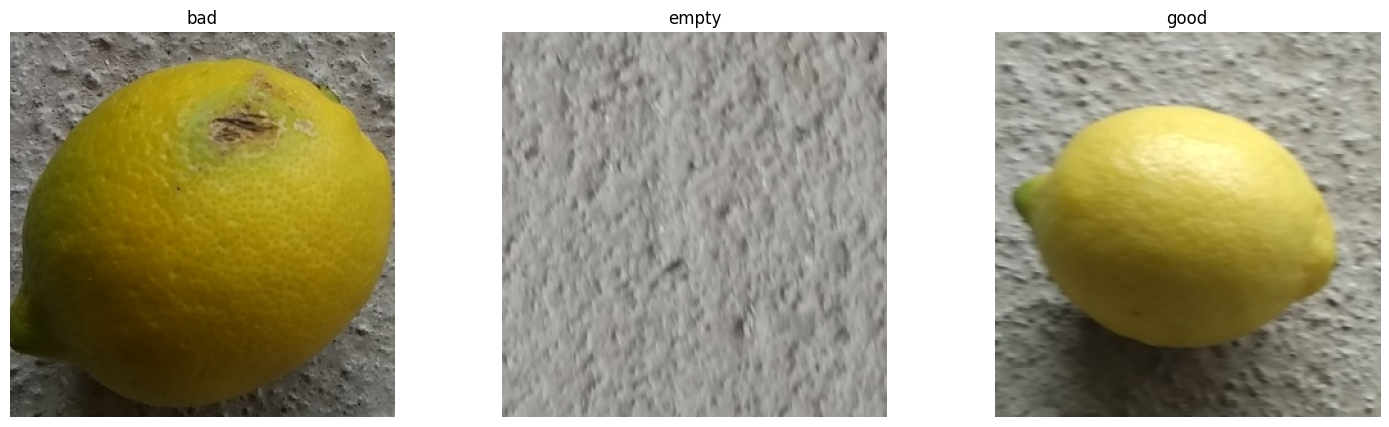

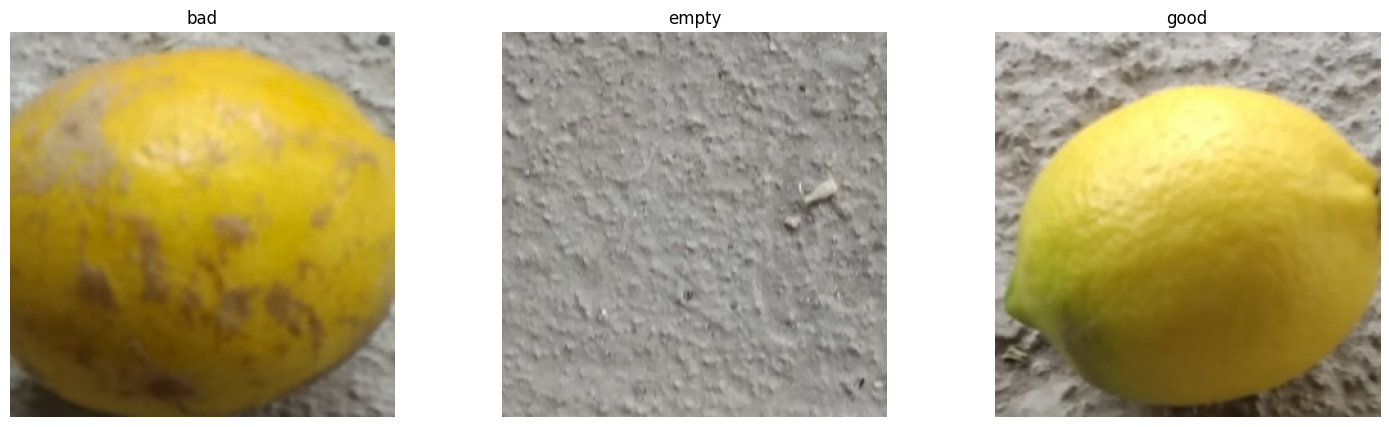

In [37]:
lemon_dataset.class_counter()
lemon_dataset.show_grid_per_class(2)
lemon_dataset.check_image_shapes()

El conjunto de datos utilizado en este proyecto fue obtenido de la plataforma Kaggle y está compuesto por imágenes de limones categorizadas en tres clases: **good_quality** (limones en buen estado), **bad_quality** (limones deteriorados) y **empty_background** (imágenes donde no aparece el fruto, utilizadas como distractores).  
El propósito de esta inspección es analizar la distribución de las clases, observar las características visuales de las imágenes y detectar posibles factores que puedan influir en el rendimiento del modelo durante el proceso de aprendizaje. Entre estos factores se consideran variaciones de iluminación, textura, enfoque, orientación y condiciones de captura en general.

### a) Distribución de imágenes por clase

La siguiente tabla muestra la cantidad de muestras disponibles por categoría:

| Clase | Cantidad |
|------|---------|
| bad_quality | 951 |
| empty_background | 452 |
| good_quality | 1125 |

Se aprecia una distribución moderadamente desbalanceada entre clases, destacando que la categoría *empty_background* contiene un número menor de imágenes. Este desbalanceo podría influir en la capacidad del modelo para aprender representaciones adecuadas de dicha clase, por lo que será considerado durante el entrenamiento mediante el uso de técnicas de *data augmentation* y regularización para evitar sesgos hacia las clases mayoritarias.

### b) Inspección visual de las imágenes

Con el fin de explorar la variabilidad intra-clase, se visualizaron múltiples imágenes pertenecientes a cada categoría. En el presente informe se incluyen únicamente **dos imágenes representativas por clase**, aunque durante la fase de análisis se revisaron diversas muestras adicionales para detectar patrones consistentes en textura, color, forma y condiciones de iluminación.

Las observaciones principales fueron las siguientes:

- Las imágenes de la clase **good_quality** presentan limones con color uniforme, textura regular y forma bien definida.
- Las imágenes pertenecientes a la clase **bad_quality** incluyen limones con manchas oscuras, zonas deterioradas, irregularidades en la superficie y variaciones de tono, lo que proporciona señales visuales útiles para la clasificación.
- Las imágenes de la clase **empty_background** muestran superficies rugosas y homogéneas (generalmente paredes), aunque con variaciones en luz y contraste que pueden generar cierto nivel de ambigüedad si el objeto aparece desenfocado o con bajo contraste respecto al fondo.

### c) Tamaño y consistencia de las imágenes

El análisis de las dimensiones del conjunto de imágenes arrojó los siguientes resultados:

| Dimensiones (H,W,C) | Cantidad |
|--------------------|----------|
| (300, 300, 3)      | 2526     |
| (292, 300, 3)      | 1        |
| (300, 296, 3)      | 1        |

Se concluye que el dataset es **prácticamente uniforme** en términos de resolución, con solo dos imágenes ligeramente divergentes. No obstante, con el fin de mantener una **comparación justa** entre la estrategia de entrenamiento desde cero y los modelos basados en *transfer learning*, se decidió **redimensionar todas las imágenes a 224×224 píxeles** durante el pipeline de carga de datos. Este tamaño es el estándar utilizado en modelos pre-entrenados sobre ImageNet y contribuye a reducir el coste computacional, además de mitigar el riesgo de sobreajuste cuando se trabaja con conjuntos de datos de tamaño medio.

### d) Resultados de la inspección

El dataset presenta una variabilidad visual suficiente para permitir el aprendizaje de patrones que diferencien las tres clases. Sin embargo, el desbalanceo de la clase *empty_background* y la presencia de variaciones en iluminación y textura hacen necesario aplicar estrategias de **data augmentation** y **regularización** para mejorar la capacidad de generalización del modelo. El uso de un **tamaño de entrada uniforme de 224×224 píxeles** permitirá asegurar la compatibilidad con arquitecturas pre-entrenadas y optimizar el rendimiento computacional durante las etapas de entrenamiento y evaluación.


## 4. Acondicionamiento

Objetivo: partición train/val/test (o K-fold si aplica), normalización, resize, data augmentation plan.

Evidencias: esquema de partición, transformaciones aplicadas y justificación.

In [56]:
lemon_genloader=LemonGenLoader()
lemon_genloader._collect_dataset()
lemon_genloader._create_splits(val_size=0.05, test_size=0.03)
train_gen, val_gen, test_gen=lemon_genloader.get_generators()



Found 2325 validated image filenames belonging to 3 classes.
Found 77 validated image filenames belonging to 3 classes.
Found 126 validated image filenames belonging to 3 classes.


## 5. Estrategia 1 (from scratch)

Objetivo: diseñar CNN propia + regularización (BN, dropout, L2, augment).

Evidencias: arquitectura (resumen/tabla), hiperparámetros, curvas de loss/accuracy y justificación.

## 6. Estrategia 2 (transfer learning)

Objetivo: probar ≥2 arquitecturas (p.ej., ResNet50 y MobileNetV2) con fine-tuning progresivo.

Evidencias: capas congeladas vs. descongeladas, LR schedule, métricas comparativas.

## 7. Monitorización y decisiones

Objetivo: early stopping, LR scheduler, selección de mejor checkpoint.

Evidencias: gráficos/metric logs y decisiones tomadas.


## 8. Evaluación final y comparación

Objetivo: métricas en test (accuracy, F1, matriz de confusión), comparación E1 vs E2.

Evidencias: tablas/resúmenes y conclusiones claras.

## 9. Conclusiones

Objetivo: discutir resultados, limitaciones y siguiente experimento sugerido.